# Transformer model fitting

This notebook contains the fitting of the Transformer model to all series in the dataset at the same time.

In [1]:
import os
import sys
import pickle
import pandas as pd
import matplotlib.pyplot as plt

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from Transformers.model_selection import TransformerHyperTune
from Transformers.data_processing import window_dataset_sequence_to_sequence
from DataSimulation.utils import plot_fit

In [2]:
data = pd.read_csv('data.csv', header=None)
data.head()

0    1     2     3     4     5     6      7     8      9   ...   90    91  \
0  6.0  3.0   6.0  95.0   7.0  34.0  63.0  354.0   5.0  152.0  ...  6.0  19.0   
1  6.0  3.0   5.0  83.0   3.0  32.0  63.0  352.0   5.0  150.0  ...  2.0  14.0   
2  5.0  3.0   8.0  83.0   4.0  33.0  71.0  343.0  10.0  152.0  ...  0.0  21.0   
3  8.0  3.0  10.0  98.0   9.0  37.0  66.0  339.0   4.0  167.0  ...  2.0  16.0   
4  6.0  5.0   7.0  85.0  12.0  28.0  61.0  324.0   2.0  169.0  ...  0.0  18.0   

     92     93    94    95    96    97    98   99  
0  23.0  217.0  34.0   9.0   6.0   5.0  24.0  7.0  
1  24.0  215.0  32.0   6.0  10.0  10.0  22.0  8.0  
2  24.0  226.0  36.0   8.0   5.0  10.0  24.0  8.0  
3  18.0  225.0  40.0  10.0   9.0  13.0  21.0  7.0  
4  17.0  208.0  39.0  14.0   6.0  10.0  20.0  9.0  

[5 rows x 100 columns]

In [3]:
test_size = 12
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
print(train_data.shape)
print(test_data.shape)

(188, 100)
(12, 100)


In [4]:
parameters = {
    "num_layers":[2],
    "num_heads":[4,6],
    "dff":[8,16],
    "dropout_rate":[0.1,0.3],
    "learning_rate":[0.01, 0.001],
    "batch_size":[1,16,32]
}

In [5]:
transformer_hypertune = TransformerHyperTune(
    num_features=100,
    window_size=12,
    parameters=parameters
)

In [6]:
transformer_model, scaler = transformer_hypertune.fit(
    data=train_data,
    checkpoint_path=os.path.join(os.getcwd(), 'checkpoint'),
    epochs=500
)

Training model 0/48.
minimum 0 model's validation loss: 0.10437681525945663.
Training model 1/48.
minimum 1 model's validation loss: 0.0979081317782402.
Training model 2/48.
minimum 2 model's validation loss: 0.0979091003537178.
Training model 3/48.
minimum 3 model's validation loss: 0.022418078035116196.
Training model 4/48.
minimum 4 model's validation loss: 0.0226278118789196.
Training model 5/48.
minimum 5 model's validation loss: 0.02307327464222908.
Training model 6/48.
minimum 6 model's validation loss: 0.10315997898578644.
Training model 7/48.
minimum 7 model's validation loss: 0.10644348710775375.
Training model 8/48.
minimum 8 model's validation loss: 0.0995207279920578.
Training model 9/48.
minimum 9 model's validation loss: 0.022654060274362564.
Training model 10/48.
minimum 10 model's validation loss: 0.022706592455506325.
Training model 11/48.
minimum 11 model's validation loss: 0.02267088182270527.
Training model 12/48.
minimum 12 model's validation loss: 0.1028052717447

time: 398m, 23.8s

In [7]:
transformer_hypertune.best_params

{'num_layers': 2,
 'num_heads': 4,
 'dff': 16,
 'dropout_rate': 0.1,
 'learning_rate': 0.001,
 'batch_size': 1}

In [8]:
scaled_data = scaler.transform(data)

In [9]:
eval_ds = window_dataset_sequence_to_sequence(
    data=scaled_data,
    sequence_lenght=12,
    output_lenght=12,
    batch_size=scaled_data.shape[0],
    shift=1,
    shuffle=False    
)

In [10]:
fit_values = transformer_model.predict(eval_ds)
fit_0 = fit_values[:,0,:]

1/1 [==============================] - 2s 2s/step


In [11]:
orig_scale = scaler.inverse_transform(fit_0)

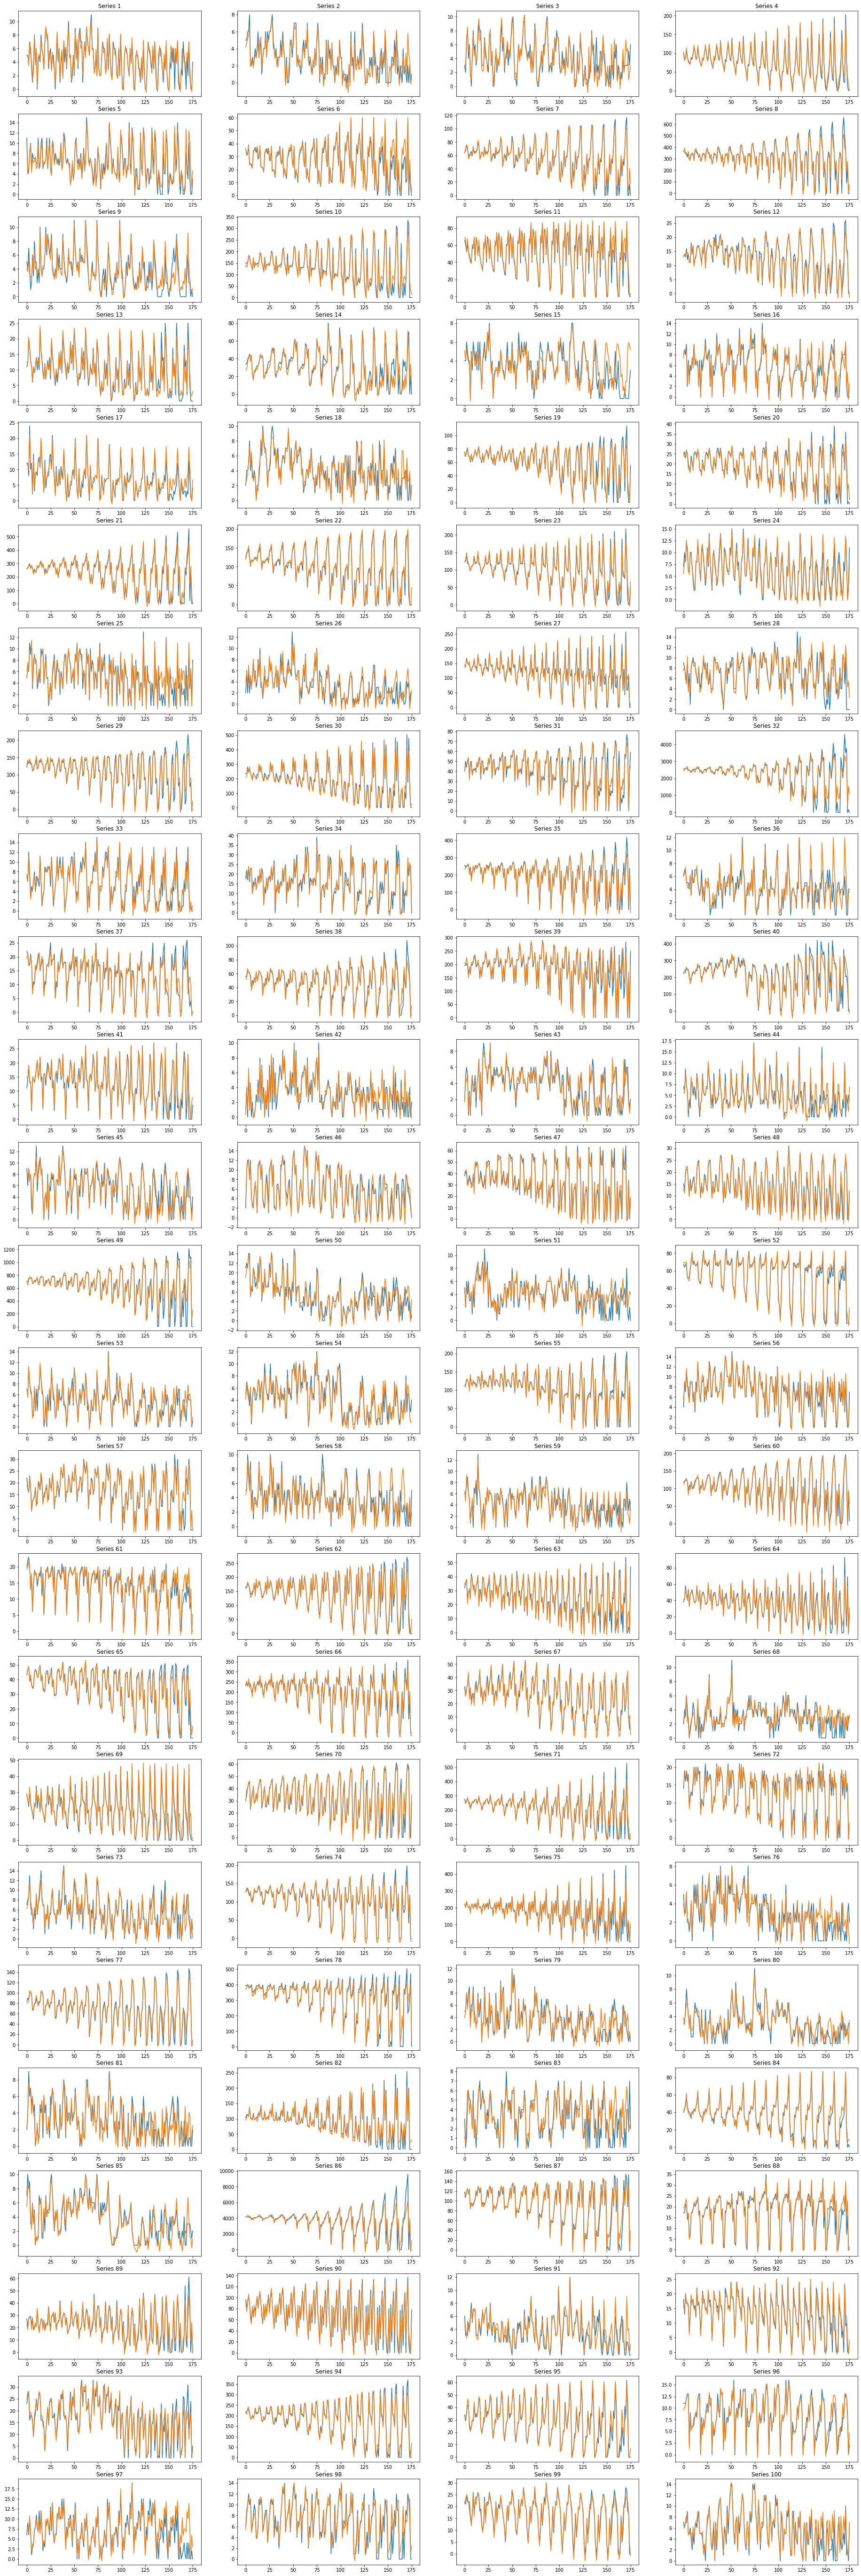

In [12]:
plot_fit(train_data[12:], orig_scale[:-1])

In [13]:
transformer_model.summary()

Model: "transformer_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_49 (Encoder)        multiple                  330232    
                                                                 
 decoder_49 (Decoder)        multiple                  653232    
                                                                 
 dense_449 (Dense)           multiple                  10100     
                                                                 
Total params: 993,564
Trainable params: 993,564
Non-trainable params: 0
_________________________________________________________________


In [14]:
transformer_model.save("transformer.tf")

INFO:tensorflow:Assets written to: transformer.tf\assets


INFO:tensorflow:Assets written to: transformer.tf\assets


In [15]:
transformer_model.save_weights('transformer_weights/transformer')

In [16]:
with open("transformer_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)